In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline

# 1. Regression Splines

The dataset fev.csv contains the measurements of forced expiratory volume (FEV) tests, evaluating the pulmonary capacity in 654 children and young adults.


In [2]:
df1 = pd.read_csv('fev.csv')
df1.head(3)

,id,age,fev,height,sex,smoke
0,301,9,1.708,57.0,female,non-current smoker
1,451,8,1.724,67.5,female,non-current smoker
2,501,7,1.720,54.5,female,non-current smoker


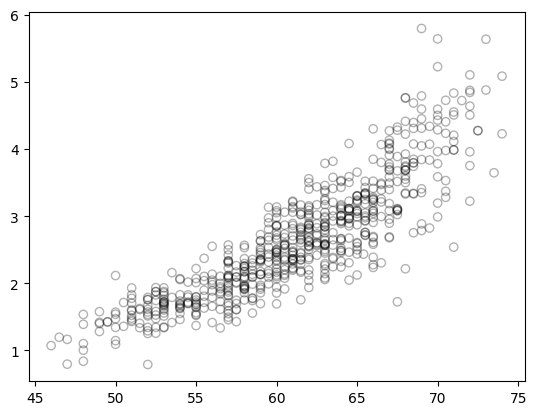

In [3]:
# Visualize the relationship b/w age and wage
plt.scatter(df1.height, df1.fev, facecolor='None', edgecolor='k', alpha=0.3)
plt.show() 

In [4]:
# Generating weights for polynomial function with degree =5
weights = np.polyfit(df1.height, df1.fev, 5)
print(weights) 

[-3.62882037e-07  1.04598980e-04 -1.19414498e-02  6.77612870e-01
 -1.90808036e+01  2.13747676e+02]


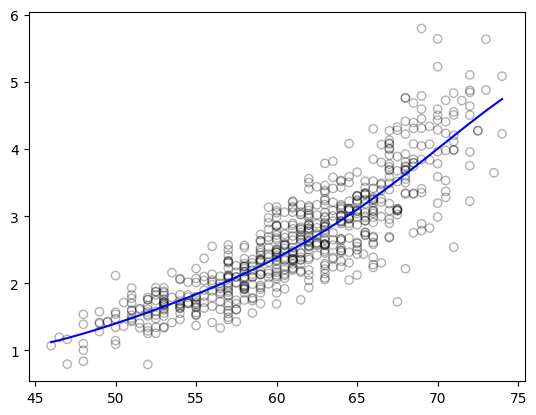

In [5]:
# Generating model with the given weights
model = np.poly1d(weights)

# Prediction on validation set
pred = model(df1.height)
# We will plot the graph for 70 observations only
xp = np.linspace(df1.height.min(),df1.height.max(),70)
pred_plot = model(xp)
plt.scatter(df1.height,df1.fev, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(xp, pred_plot, color='blue')
plt.show()

### Utility Functions

In [6]:
def load_data():
    df = pd.read_csv('fev.csv')
    return df


def plot_model(X, y, X_plot=None, y_pred=None, title='',
               curve_label='', curve_color='r', curve_style='-',
               knots_X=None, knots_y=None, show_data_label=True):
    plt.figure(figsize=(10, 6))

    data_label = 'Data' if show_data_label else None
    plt.scatter(X, y, alpha=0.5, edgecolors='k', facecolors='none', label=data_label)

    if X_plot is not None and y_pred is not None:
        plt.plot(X_plot, y_pred, color=curve_color, linestyle=curve_style,
                linewidth=2, label=curve_label)

    if knots_X is not None and knots_y is not None:
        plt.scatter(knots_X, knots_y, color='red', s=100, zorder=5,
                   label=f'Knots (n={len(knots_X)})')

    plt.xlabel('Height', fontsize=12)
    plt.ylabel('FEV', fontsize=12)
    plt.title(title, fontsize=14)
    if curve_label or show_data_label or (knots_X is not None):
        plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_overlay_comparison(X, y, X_plot, results, contexts, title=None):
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.scatter(
        X, y,
        alpha=0.5,
        edgecolors='k',
        facecolors='none',
        s=50,
        label='Data',
        zorder=1,
    )

    for model in results:
        library = model['Library']
        context = contexts[library]
        y_curve = context['predict'](X_plot)

        overlay_kwargs = context.get('overlay_kwargs', {}).copy()
        label = f'{library} (MSE={model["MSE"]:.4f})'
        ax.plot(X_plot, y_curve, label=label, **overlay_kwargs)

    ax.set_xlabel('Height', fontsize=14, fontweight='bold')
    ax.set_ylabel('FEV', fontsize=14, fontweight='bold')
    plot_title = title or 'Spline Comparison: FEV vs Height'
    ax.set_title(plot_title, fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=11, loc='upper left', framealpha=0.95)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    plt.close(fig)

def print_summary(metrics, df_value=None):
    heading = f"\nSummary Metrics (df={df_value})" if df_value is not None else "\nSummary Metrics"
    print(heading)
    print("-" * 80)
    ordered = sorted(metrics, key=lambda m: m['MSE'])
    headers = ["Library"]
    if any('df' in row for row in ordered):
        headers.append("df")
    if any('Parameter' in row for row in ordered):
        headers.append("Parameter")
    headers.extend(["R²", "MSE", "RMSE"])
    print(" ".join(headers))
    for row in ordered:
        fields = [row['Library']]
        if 'df' in row:
            fields.append(str(row['df']))
        if 'Parameter' in row:
            fields.append(row['Parameter'])
        fields.extend([
            f"{row['R²']:.6f}",
            f"{row['MSE']:.6f}",
            f"{row['RMSE']:.6f}",
        ])
        print(" ".join(fields))

### 1. Plot: Association between FEV and Height

Dataset: 654 observations
Height range: [46.00, 74.00]
FEV range: [0.79, 5.79]


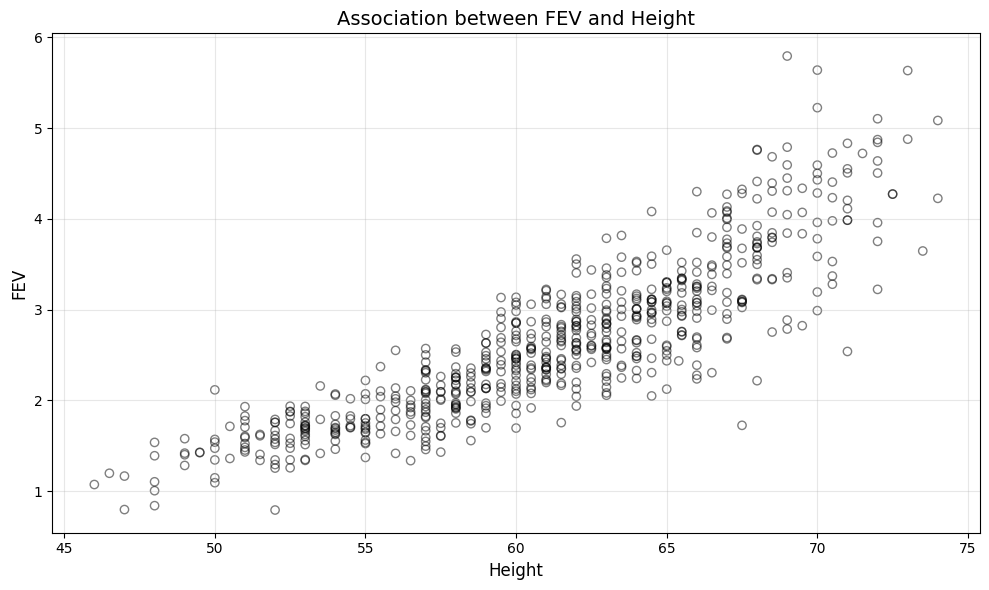

In [7]:
df = load_data()
X = df['height'].to_numpy()
y = df['fev'].to_numpy()

print(f"Dataset: {len(X)} observations")
print(f"Height range: [{X.min():.2f}, {X.max():.2f}]")
print(f"FEV range: [{y.min():.2f}, {y.max():.2f}]")

plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5, edgecolors='k', facecolors='none')
plt.xlabel('Height', fontsize=12)
plt.ylabel('FEV', fontsize=12)
plt.title('Association between FEV and Height', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 2. Linear Model: FEV vs Height

#### Define fitting functions for each library

In [8]:
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from pygam import LinearGAM, l

def fit_scipy_linear(X, y):
    print("1. scipy.stats.linregress")
    print("-" * 40)
    result = stats.linregress(X, y)
    slope = result.slope
    intercept = result.intercept
    r2 = pow(result.rvalue, 2)
    y_pred = slope * X + intercept
    mse = mean_squared_error(y, y_pred)
    rmse = sqrt(mse)

    print(f"Intercept: {intercept:.10f}")
    print(f"Slope: {slope:.10f}")
    print(f"R²: {r2:.10f}")
    print(f"MSE: {mse:.10f}")
    print(f"RMSE: {rmse:.10f}")

    result_dict = {
        'Library': 'scipy.stats',
        'Intercept': intercept,
        'Slope': slope,
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse
    }

    context = {
        'predict': lambda arr, slope=slope, intercept=intercept: slope * np.asarray(arr) + intercept,
        'overlay_kwargs': {'color': 'crimson', 'linestyle': '-', 'linewidth': 2.5, 'alpha': 0.85},
    }

    return result_dict, context


def fit_statsmodels_linear(X, y, df):
    print("\n2. statsmodels.formula.api")
    print("-" * 40)
    model = smf.ols('fev ~ height', data=df).fit()
    intercept = model.params['Intercept']
    slope = model.params['height']
    r2 = model.rsquared
    y_pred = model.predict(df)
    mse = mean_squared_error(y, y_pred)
    rmse = sqrt(mse)

    print(f"Intercept: {intercept:.10f}")
    print(f"Slope: {slope:.10f}")
    print(f"R²: {r2:.10f}")
    print(f"MSE: {mse:.10f}")
    print(f"RMSE: {rmse:.10f}")

    result_dict = {
        'Library': 'statsmodels',
        'Intercept': intercept,
        'Slope': slope,
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse
    }

    context = {
        'predict': lambda arr, slope=slope, intercept=intercept: slope * np.asarray(arr) + intercept,
        'overlay_kwargs': {'color': 'navy', 'linestyle': '--', 'linewidth': 2.5, 'alpha': 0.85},
    }

    return result_dict, context


def fit_sklearn_linear(X, y):
    print("\n3. sklearn.linear_model.LinearRegression")
    print("-" * 40)
    model = LinearRegression()
    model.fit(X.reshape(-1, 1), y)
    intercept = model.intercept_
    slope = model.coef_[0]
    y_pred = model.predict(X.reshape(-1, 1))
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = sqrt(mse)

    print(f"Intercept: {intercept:.10f}")
    print(f"Slope: {slope:.10f}")
    print(f"R²: {r2:.10f}")
    print(f"MSE: {mse:.10f}")
    print(f"RMSE: {rmse:.10f}")

    result_dict = {
        'Library': 'sklearn',
        'Intercept': intercept,
        'Slope': slope,
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse
    }

    context = {
        'predict': lambda arr, slope=slope, intercept=intercept: slope * np.asarray(arr) + intercept,
        'overlay_kwargs': {'color': 'darkgreen', 'linestyle': '-.', 'linewidth': 2.5, 'alpha': 0.85},
    }

    return result_dict, context


def fit_pygam_linear(X, y):
    print("\n4. pyGAM.LinearGAM with l()")
    print("-" * 40)
    gam = LinearGAM(l(0))
    gam.fit(X.reshape(-1, 1), y)
    slope = gam.coef_[0]
    intercept = gam.coef_[1]
    y_pred = gam.predict(X.reshape(-1, 1))
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = sqrt(mse)

    print(f"Intercept: {intercept:.10f}")
    print(f"Slope: {slope:.10f}")
    print(f"R²: {r2:.10f}")
    print(f"MSE: {mse:.10f}")
    print(f"RMSE: {rmse:.10f}")

    result_dict = {
        'Library': 'pyGAM',
        'Intercept': intercept,
        'Slope': slope,
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse
    }

    context = {
        'predict': lambda arr, slope=slope, intercept=intercept: slope * np.asarray(arr) + intercept,
        'overlay_kwargs': {'color': 'orange', 'linestyle': ':', 'linewidth': 2.5, 'alpha': 0.85},
    }

    return result_dict, context

#### Fit and compare all linear models

1. scipy.stats.linregress
----------------------------------------
Intercept: -5.4326787993
Slope: 0.1319755710
R²: 0.7536583940
MSE: 0.1849143439
RMSE: 0.4300166786

2. statsmodels.formula.api
----------------------------------------
Intercept: -5.4326787993
Slope: 0.1319755710
R²: 0.7536583940
MSE: 0.1849143439
RMSE: 0.4300166786

3. sklearn.linear_model.LinearRegression
----------------------------------------
Intercept: -5.4326787993
Slope: 0.1319755710
R²: 0.7536583940
MSE: 0.1849143439
RMSE: 0.4300166786

4. pyGAM.LinearGAM with l()
----------------------------------------
Intercept: -5.4324508634
Slope: 0.1319718431
R²: 0.7536583934
MSE: 0.1849143443
RMSE: 0.4300166791

Summary Metrics
--------------------------------------------------------------------------------
Library R² MSE RMSE
scipy.stats 0.753658 0.184914 0.430017
statsmodels 0.753658 0.184914 0.430017
sklearn 0.753658 0.184914 0.430017
pyGAM 0.753658 0.184914 0.430017

Best Model (by MSE): scipy.stats
FEV = 0.1320 × He

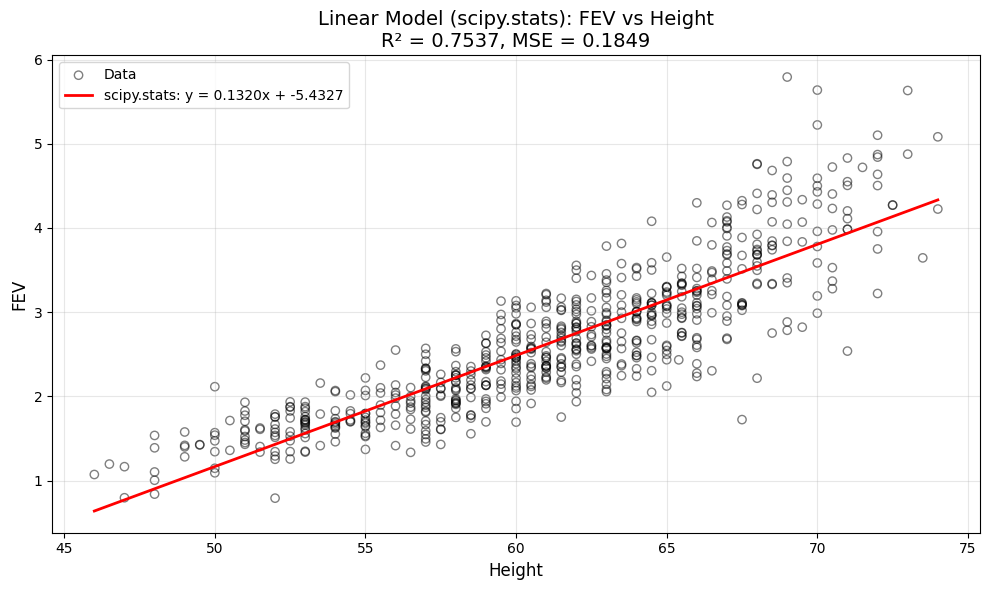

In [9]:
results_linear = []
contexts_linear = {}

scipy_result, scipy_context = fit_scipy_linear(X, y)
results_linear.append(scipy_result)
contexts_linear['scipy.stats'] = scipy_context

statsmodels_result, statsmodels_context = fit_statsmodels_linear(X, y, df)
results_linear.append(statsmodels_result)
contexts_linear['statsmodels'] = statsmodels_context

sklearn_result, sklearn_context = fit_sklearn_linear(X, y)
results_linear.append(sklearn_result)
contexts_linear['sklearn'] = sklearn_context

pygam_result, pygam_context = fit_pygam_linear(X, y)
results_linear.append(pygam_result)
contexts_linear['pyGAM'] = pygam_context

print_summary(results_linear)

best_model = min(results_linear, key=lambda r: r['MSE'])
best_library = best_model['Library']
best_slope = best_model['Slope']
best_intercept = best_model['Intercept']
best_r2 = best_model['R²']
best_mse = best_model['MSE']
best_rmse = best_model['RMSE']

print(f"\nBest Model (by MSE): {best_library}")
print(f"FEV = {best_slope:.4f} × Height + {best_intercept:.4f}")
print(f"R² = {best_r2:.4f}")
print(f"MSE = {best_mse:.6f}")
print(f"RMSE = {best_rmse:.6f}")

X_plot = np.linspace(X.min(), X.max(), 100)
y_plot = best_slope * X_plot + best_intercept

plot_model(X, y, X_plot, y_plot,
          title=f'Linear Model ({best_library}): FEV vs Height\nR² = {best_r2:.4f}, MSE = {best_mse:.4f}',
          curve_label=f'{best_library}: y = {best_slope:.4f}x + {best_intercept:.4f}',
          curve_color='r')

### 3. Natural Cubic Spline: df=5 and df=10

#### Define fitting functions for natural cubic splines

In [10]:
from scipy import linalg
from patsy import dmatrix
from pygam import s
from csaps import CubicSmoothingSpline

def fit_scipy_natural(basis, y, X, transform, knots_x, df_value):
    print("\nscipy")
    print("-" * 40)
    coeffs, _, _, _ = linalg.lstsq(basis, y)
    predict_fn = lambda arr, coeffs=coeffs: transform(arr) @ coeffs
    y_pred = predict_fn(X)
    mse = mean_squared_error(y, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y, y_pred)
    print(f"R²: {r2:.10f}")
    print(f"MSE: {mse:.10f}")
    print(f"RMSE: {rmse:.10f}")

    result = {
        'Library': 'scipy',
        'df': df_value,
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
    }

    context = {
        'predict': predict_fn,
        'knots_x': knots_x,
        'knots_y': predict_fn(knots_x),
        'overlay_kwargs': {'color': 'crimson', 'linestyle': '-', 'linewidth': 2.5, 'alpha': 0.85, 'zorder': 2},
    }

    return result, context


def fit_statsmodels_natural(basis, y, X, transform, knots_x, df_value):
    print("\nstatsmodels")
    print("-" * 40)
    model = sm.OLS(y, basis).fit()
    params = np.asarray(model.params)
    predict_fn = lambda arr, params=params: transform(arr) @ params
    y_pred = predict_fn(X)
    mse = mean_squared_error(y, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y, y_pred)
    print(f"R²: {r2:.10f}")
    print(f"MSE: {mse:.10f}")
    print(f"RMSE: {rmse:.10f}")

    result = {
        'Library': 'statsmodels',
        'df': df_value,
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
    }

    context = {
        'predict': predict_fn,
        'knots_x': knots_x,
        'knots_y': predict_fn(knots_x),
        'overlay_kwargs': {'color': 'navy', 'linestyle': '--', 'linewidth': 2.5, 'alpha': 0.85, 'zorder': 3},
    }

    return result, context


def fit_sklearn_natural(basis, y, X, transform, knots_x, df_value):
    print("\nsklearn")
    print("-" * 40)
    linear_reg = LinearRegression(fit_intercept=False)
    linear_reg.fit(basis, y)
    coeffs = linear_reg.coef_
    predict_fn = lambda arr, coeffs=coeffs: transform(arr) @ coeffs
    y_pred = predict_fn(X)
    mse = mean_squared_error(y, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y, y_pred)
    print(f"R²: {r2:.10f}")
    print(f"MSE: {mse:.10f}")
    print(f"RMSE: {rmse:.10f}")

    result = {
        'Library': 'sklearn',
        'df': df_value,
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
    }

    context = {
        'predict': predict_fn,
        'knots_x': knots_x,
        'knots_y': predict_fn(knots_x),
        'overlay_kwargs': {'color': 'darkgreen', 'linestyle': '-.', 'linewidth': 2.5, 'alpha': 0.85, 'zorder': 4},
    }

    return result, context


def fit_pygam_natural(X, y, df_value, knots_x):
    print("\npyGAM")
    print("-" * 40)
    gam = LinearGAM(s(0, n_splines=df_value, spline_order=3)).gridsearch(
        X.reshape(-1, 1),
        y,
        lam=np.logspace(-4, 4, 20),
    )
    predict_fn = lambda arr, model=gam: model.predict(np.asarray(arr).reshape(-1, 1))
    y_pred = predict_fn(X)
    mse = mean_squared_error(y, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y, y_pred)
    print(f"R²: {r2:.10f}")
    print(f"MSE: {mse:.10f}")
    print(f"RMSE: {rmse:.10f}")

    result = {
        'Library': 'pyGAM',
        'df': df_value,
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
    }

    context = {
        'predict': predict_fn,
        'knots_x': knots_x,
        'knots_y': predict_fn(knots_x),
        'overlay_kwargs': {'color': 'orange', 'linestyle': '-', 'linewidth': 2.5, 'alpha': 0.75, 'zorder': 5},
    }

    return result, context


def fit_csaps_natural(knots_x, knots_y_samples, X, y, df_value):
    print("\ncsaps")
    print("-" * 40)
    spline = CubicSmoothingSpline(knots_x, knots_y_samples, smooth=0.0)
    predict_fn = lambda arr, spline=spline: spline(np.asarray(arr))
    y_pred = predict_fn(X)
    mse = mean_squared_error(y, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y, y_pred)
    print(f"R²: {r2:.10f}")
    print(f"MSE: {mse:.10f}")
    print(f"RMSE: {rmse:.10f}")

    result = {
        'Library': 'csaps',
        'df': df_value,
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
    }

    context = {
        'predict': predict_fn,
        'knots_x': knots_x,
        'knots_y': predict_fn(knots_x),
        'overlay_kwargs': {'color': 'purple', 'linestyle': ':', 'linewidth': 2.5, 'alpha': 0.85, 'zorder': 6},
    }

    return result, context


def evaluate_natural_splines(X, y, df_value):
    basis_df = dmatrix(f"cr(x, df={df_value})", {"x": X}, return_type='dataframe')
    design_info = basis_df.design_info
    basis = np.asarray(basis_df)

    def transform(values):
        values = np.asarray(values, dtype=float)
        return np.asarray(dmatrix(design_info, {"x": values}, return_type='dataframe'))

    unique_x, inverse = np.unique(X, return_inverse=True)
    unique_y = np.array([y[inverse == i].mean() for i in range(len(unique_x))])

    raw_knots = np.quantile(unique_x, np.linspace(0, 1, df_value))
    knot_indices = sorted(set(np.argmin(np.abs(unique_x - k)) for k in raw_knots))
    knots_x = unique_x[knot_indices]
    knots_y_samples = unique_y[knot_indices]

    results = []
    contexts = {}

    scipy_result, scipy_context = fit_scipy_natural(basis, y, X, transform, knots_x, df_value)
    results.append(scipy_result)
    contexts['scipy'] = scipy_context

    stats_result, stats_context = fit_statsmodels_natural(basis, y, X, transform, knots_x, df_value)
    results.append(stats_result)
    contexts['statsmodels'] = stats_context

    sklearn_result, sklearn_context = fit_sklearn_natural(basis, y, X, transform, knots_x, df_value)
    results.append(sklearn_result)
    contexts['sklearn'] = sklearn_context

    pygam_result, pygam_context = fit_pygam_natural(X, y, df_value, knots_x)
    results.append(pygam_result)
    contexts['pyGAM'] = pygam_context

    csaps_result, csaps_context = fit_csaps_natural(knots_x, knots_y_samples, X, y, df_value)
    results.append(csaps_result)
    contexts['csaps'] = csaps_context

    return results, contexts

#### Fit and evaluate natural cubic splines (df=5 and df=10)

  0% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


Testing df=5 and df=10


scipy
----------------------------------------
R²: 0.7741234188
MSE: 0.1695524377
RMSE: 0.4117674558

statsmodels
----------------------------------------
R²: 0.7746946374
MSE: 0.1691236571
RMSE: 0.4112464676

sklearn
----------------------------------------
R²: 0.7741234188
MSE: 0.1695524377
RMSE: 0.4117674558

pyGAM
----------------------------------------


 75% (15 of 20) |##################      | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


R²: 0.7740280631
MSE: 0.1696240157
RMSE: 0.4118543622

csaps
----------------------------------------
R²: 0.7178070907
MSE: 0.2118258361
RMSE: 0.4602454086

scipy
----------------------------------------
R²: 0.7805915473
MSE: 0.1646971891
RMSE: 0.4058290146

statsmodels
----------------------------------------
R²: 0.7807146812
MSE: 0.1646047597
RMSE: 0.4057151213

sklearn
----------------------------------------
R²: 0.7805915473
MSE: 0.1646971891
RMSE: 0.4058290146

pyGAM
----------------------------------------
R²: 0.7793589399
MSE: 0.1656224359
RMSE: 0.4069673647

csaps
----------------------------------------
R²: 0.7461340713
MSE: 0.1905624161
RMSE: 0.4365345532

Summary Metrics (df=5)
--------------------------------------------------------------------------------
Library df R² MSE RMSE
statsmodels 5 0.774695 0.169124 0.411246
scipy 5 0.774123 0.169552 0.411767
sklearn 5 0.774123 0.169552 0.411767
pyGAM 5 0.774028 0.169624 0.411854
csaps 5 0.717807 0.211826 0.460245

Summary Metric

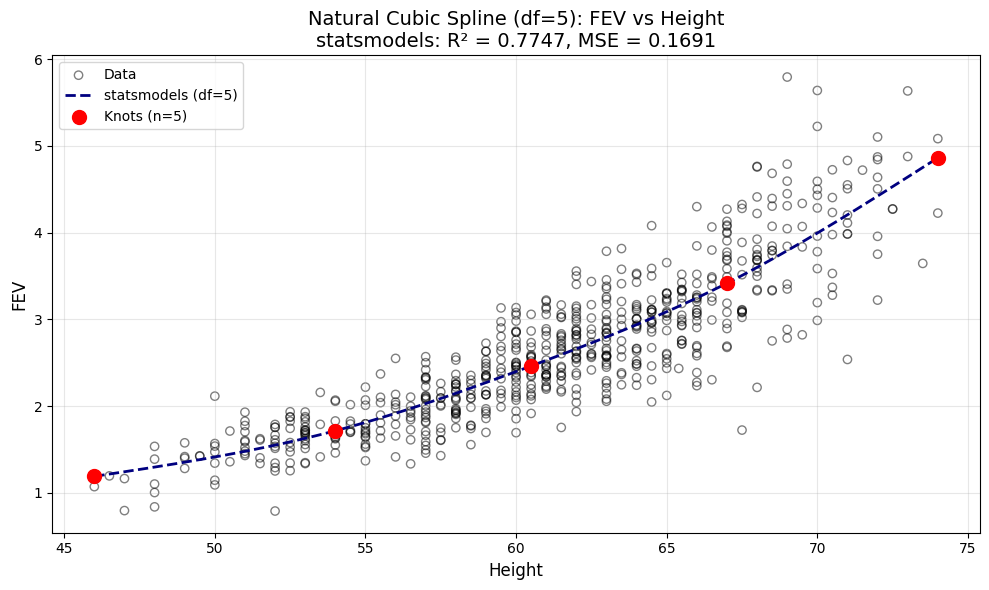

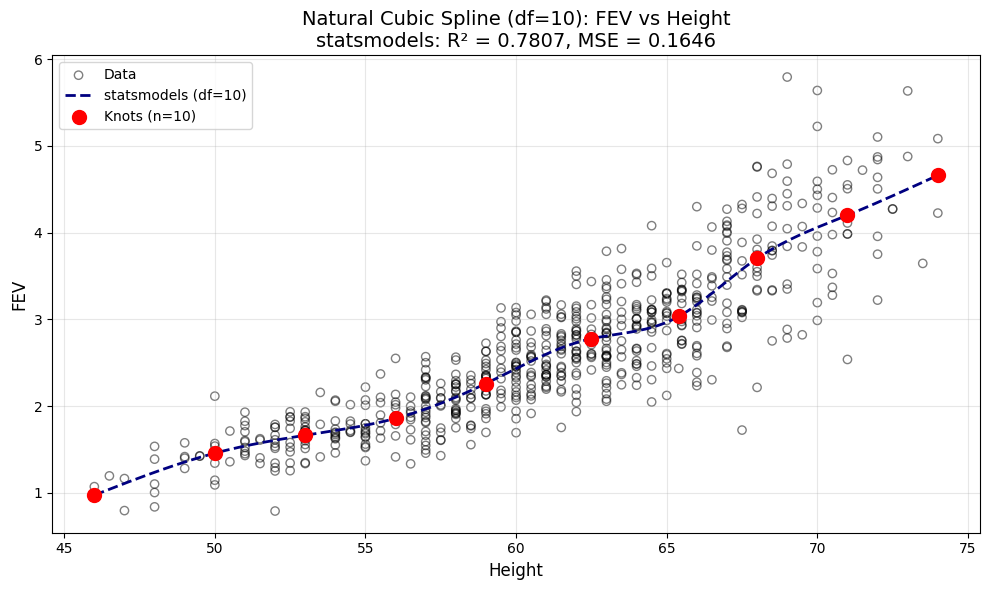

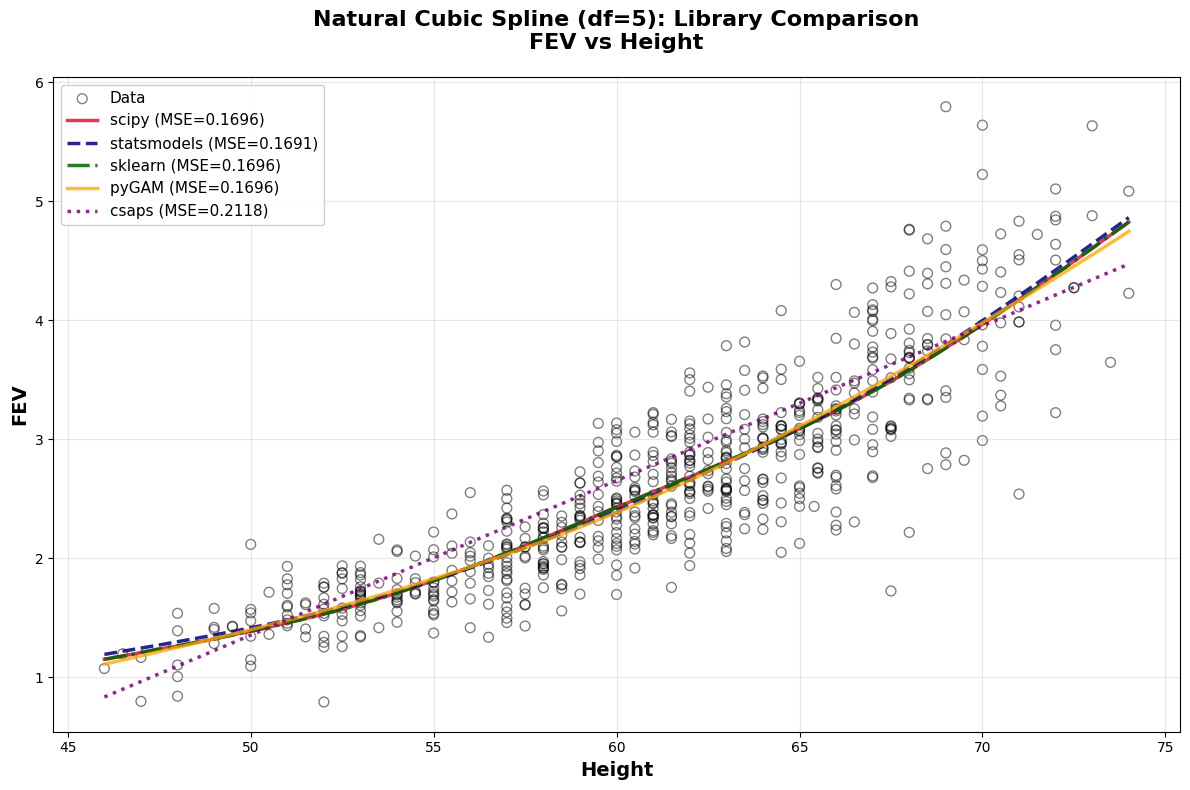

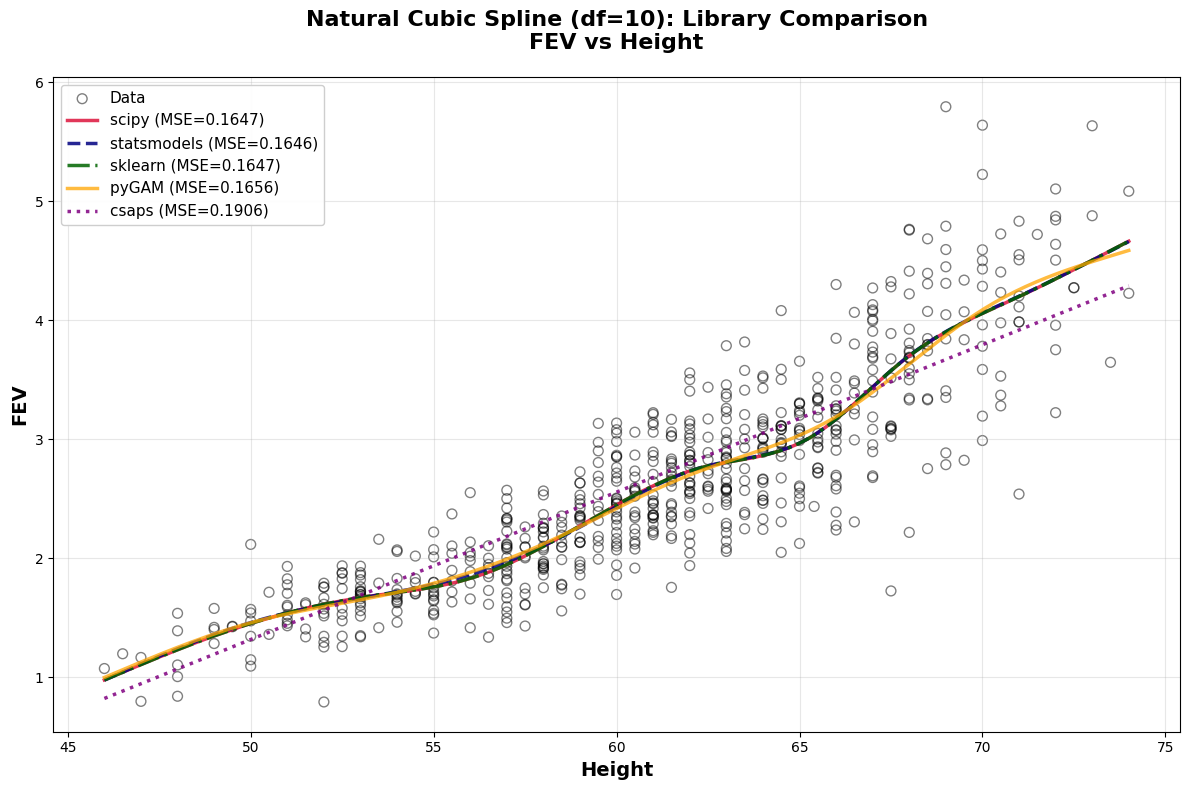

In [11]:
print(f"Testing df=5 and df=10\n")

results_df5, curve_context_5 = evaluate_natural_splines(X, y, df_value=5)
results_df10, curve_context_10 = evaluate_natural_splines(X, y, df_value=10)

print_summary(results_df5, df_value=5)
print_summary(results_df10, df_value=10)

X_plot = np.linspace(X.min(), X.max(), 200)

best_df5 = min(results_df5, key=lambda r: r['MSE'])
context_df5 = curve_context_5[best_df5['Library']]

plot_model(
    X,
    y,
    X_plot,
    context_df5['predict'](X_plot),
    title=(f'Natural Cubic Spline (df=5): FEV vs Height\n'
           f'{best_df5["Library"]}: R² = {best_df5["R²"]:.4f}, MSE = {best_df5["MSE"]:.4f}'),
    curve_label=f'{best_df5["Library"]} (df=5)',
    curve_color=context_df5['overlay_kwargs']['color'],
    curve_style=context_df5['overlay_kwargs']['linestyle'],
    knots_X=context_df5['knots_x'],
    knots_y=context_df5['knots_y'],
)

best_df10 = min(results_df10, key=lambda r: r['MSE'])
context_df10 = curve_context_10[best_df10['Library']]

plot_model(
    X,
    y,
    X_plot,
    context_df10['predict'](X_plot),
    title=(f'Natural Cubic Spline (df=10): FEV vs Height\n'
           f'{best_df10["Library"]}: R² = {best_df10["R²"]:.4f}, MSE = {best_df10["MSE"]:.4f}'),
    curve_label=f'{best_df10["Library"]} (df=10)',
    curve_color=context_df10['overlay_kwargs']['color'],
    curve_style=context_df10['overlay_kwargs']['linestyle'],
    knots_X=context_df10['knots_x'],
    knots_y=context_df10['knots_y'],
)

plot_overlay_comparison(
    X=X,
    y=y,
    X_plot=X_plot,
    results=results_df5,
    contexts=curve_context_5,
    title='Natural Cubic Spline (df=5): Library Comparison\nFEV vs Height',
)

plot_overlay_comparison(
    X=X,
    y=y,
    X_plot=X_plot,
    results=results_df10,
    contexts=curve_context_10,
    title='Natural Cubic Spline (df=10): Library Comparison\nFEV vs Height',
)

### 4. Smoothing Cubic Spline with Cross-Validation

#### Define cross-validation and fitting functions

In [12]:
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import KFold

def cross_validate_univariate_spline(x, y, s_values, cv):
    best_s = None
    best_mse = float("inf")

    for s_val in s_values:
        fold_errors = []
        for train_idx, val_idx in cv.split(x):
            x_train = x[train_idx]
            y_train = y[train_idx]
            order = np.argsort(x_train)
            spline = UnivariateSpline(x_train[order], y_train[order], s=float(s_val))
            y_val_pred = spline(x[val_idx])
            fold_errors.append(mean_squared_error(y[val_idx], y_val_pred))
        mean_error = float(np.mean(fold_errors))
        if mean_error < best_mse:
            best_mse = mean_error
            best_s = s_val

    return float(best_s)


def cross_validate_csaps(x, y, smooth_values, cv):
    best_smooth = None
    best_mse = float("inf")

    for smooth_val in smooth_values:
        fold_errors = []
        for train_idx, val_idx in cv.split(x):
            x_train = x[train_idx]
            y_train = y[train_idx]
            order = np.argsort(x_train)
            spline = CubicSmoothingSpline(
                x_train[order],
                y_train[order],
                smooth=float(smooth_val),
            )
            y_val_pred = spline(x[val_idx])
            fold_errors.append(mean_squared_error(y[val_idx], y_val_pred))
        mean_error = float(np.mean(fold_errors))
        if mean_error < best_mse:
            best_mse = mean_error
            best_smooth = smooth_val

    return float(best_smooth)


def fit_scipy_smoothing(unique_x, unique_y, X_full, y_full, cv):
    print("scipy.interpolate.UnivariateSpline (CV)")
    print("-" * 40)
    s_candidates = np.logspace(-2, 3, 30) * len(unique_x)
    best_s = cross_validate_univariate_spline(unique_x, unique_y, s_candidates, cv)
    spline = UnivariateSpline(unique_x, unique_y, s=best_s)
    y_pred = spline(X_full)
    mse = mean_squared_error(y_full, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_full, y_pred)
    print(f"Best s: {best_s:.6f}")
    print(f"R²: {r2:.6f}")
    print(f"MSE: {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")

    result = {
        'Library': 'scipy',
        'Parameter': f's={best_s:.6f}',
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
    }

    context = {
        'predict': lambda arr, model=spline: model(np.asarray(arr)),
        'overlay_kwargs': {'color': 'crimson', 'linestyle': '-', 'linewidth': 2.5, 'alpha': 0.85},
    }

    return result, context


def fit_csaps_smoothing(unique_x, unique_y, X_full, y_full, cv):
    print("\ncsaps.CubicSmoothingSpline (CV)")
    print("-" * 40)
    smooth_candidates = np.linspace(0.0, 1.0, 21)
    best_smooth = cross_validate_csaps(unique_x, unique_y, smooth_candidates, cv)
    spline = CubicSmoothingSpline(unique_x, unique_y, smooth=best_smooth)
    y_pred = spline(X_full)
    mse = mean_squared_error(y_full, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_full, y_pred)
    print(f"Best smooth: {best_smooth:.6f}")
    print(f"R²: {r2:.6f}")
    print(f"MSE: {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")

    result = {
        'Library': 'csaps',
        'Parameter': f'smooth={best_smooth:.6f}',
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
    }

    context = {
        'predict': lambda arr, model=spline: model(np.asarray(arr)),
        'overlay_kwargs': {'color': 'navy', 'linestyle': '--', 'linewidth': 2.5, 'alpha': 0.85},
    }

    return result, context


def fit_pygam_smoothing(X_full, y_full):
    print("\npyGAM.LinearGAM (GCV)")
    print("-" * 40)
    X_gam = X_full.reshape(-1, 1)
    gam = LinearGAM(s(0)).gridsearch(X_gam, y_full)
    best_lambda = float(gam.lam[0][0])
    y_pred = gam.predict(X_gam)
    mse = mean_squared_error(y_full, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_full, y_pred)
    print(f"Best lambda: {best_lambda:.6f}")
    print(f"R²: {r2:.6f}")
    print(f"MSE: {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")

    result = {
        'Library': 'pyGAM',
        'Parameter': f'λ={best_lambda:.6f}',
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
    }

    context = {
        'predict': lambda arr, model=gam: model.predict(np.asarray(arr).reshape(-1, 1)),
        'overlay_kwargs': {'color': 'darkgreen', 'linestyle': '-.', 'linewidth': 2.5, 'alpha': 0.85},
    }

    return result, context

#### Fit and evaluate smoothing splines with cross-validation

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


scipy.interpolate.UnivariateSpline (CV)
----------------------------------------
Best s: 4.076214
R²: 0.773364
MSE: 0.170122
RMSE: 0.412459

csaps.CubicSmoothingSpline (CV)
----------------------------------------
Best smooth: 0.050000
R²: 0.777833
MSE: 0.166768
RMSE: 0.408372

pyGAM.LinearGAM (GCV)
----------------------------------------
Best lambda: 15.848932
R²: 0.779479
MSE: 0.165532
RMSE: 0.406856

Summary Metrics
--------------------------------------------------------------------------------
Library Parameter R² MSE RMSE
pyGAM λ=15.848932 0.779479 0.165532 0.406856
csaps smooth=0.050000 0.777833 0.166768 0.408372
scipy s=4.076214 0.773364 0.170122 0.412459


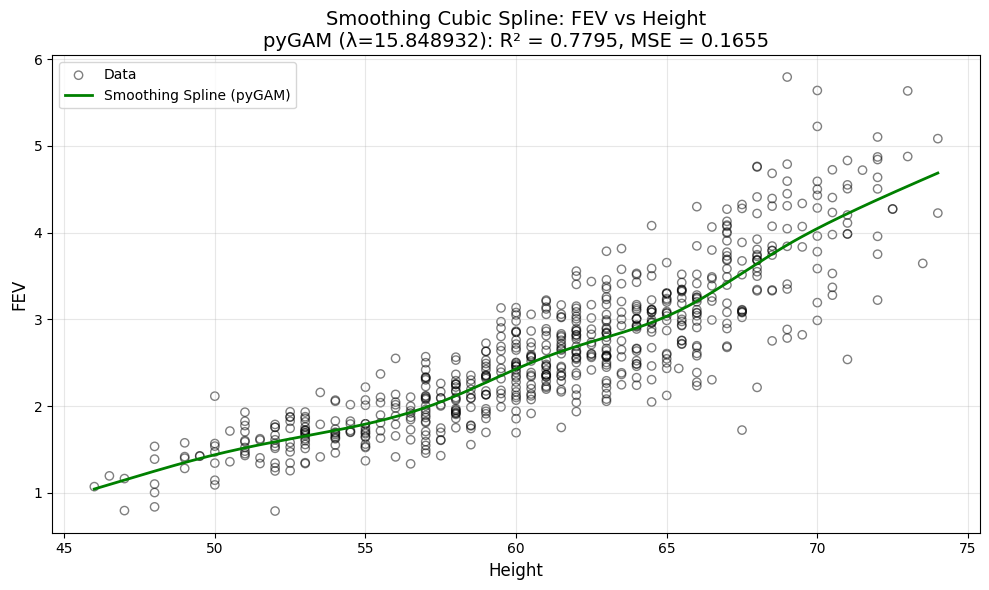

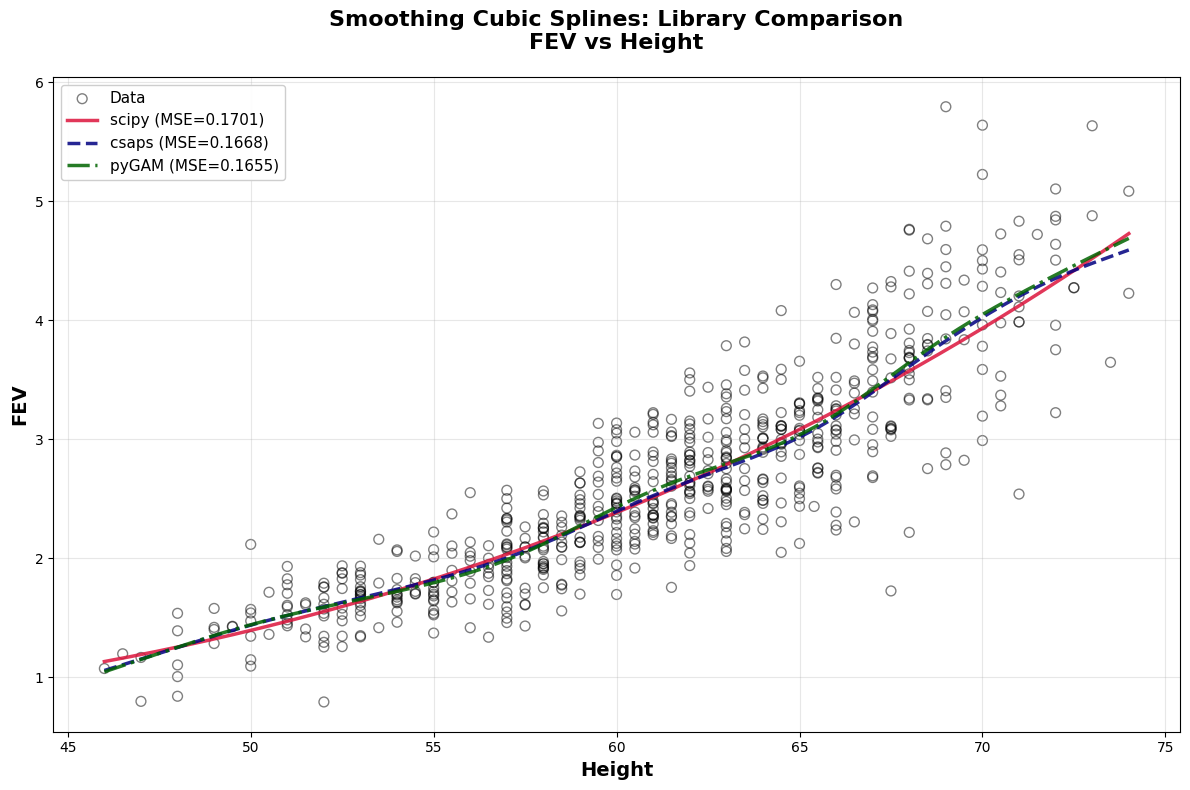

In [13]:
sort_idx = np.argsort(X)
X_sorted = X[sort_idx]
y_sorted = y[sort_idx]
unique_x, inverse = np.unique(X_sorted, return_inverse=True)
unique_y = np.array([y_sorted[inverse == i].mean() for i in range(len(unique_x))])

cv = KFold(n_splits=5, shuffle=True, random_state=42)

results_smoothing = []
contexts_smoothing = {}

scipy_result, scipy_context = fit_scipy_smoothing(unique_x, unique_y, X, y, cv)
results_smoothing.append(scipy_result)
contexts_smoothing['scipy'] = scipy_context

csaps_result, csaps_context = fit_csaps_smoothing(unique_x, unique_y, X, y, cv)
results_smoothing.append(csaps_result)
contexts_smoothing['csaps'] = csaps_context

pygam_result, pygam_context = fit_pygam_smoothing(X, y)
results_smoothing.append(pygam_result)
contexts_smoothing['pyGAM'] = pygam_context

print_summary(results_smoothing)

best_model = min(results_smoothing, key=lambda r: r['MSE'])
best_label = best_model['Library']
best_param = best_model['Parameter']

X_plot = np.linspace(X.min(), X.max(), 200)
y_plot = contexts_smoothing[best_label]['predict'](X_plot)

plot_model(
    X,
    y,
    X_plot,
    y_plot,
    title=(f'Smoothing Cubic Spline: FEV vs Height\n'
           f'{best_label} ({best_param}): R² = {best_model["R²"]:.4f}, MSE = {best_model["MSE"]:.4f}'),
    curve_label=f'Smoothing Spline ({best_label})',
    curve_color='g',
)

plot_overlay_comparison(
    X=X,
    y=y,
    X_plot=X_plot,
    results=results_smoothing,
    contexts=contexts_smoothing,
    title='Smoothing Cubic Splines: Library Comparison\nFEV vs Height',
)

### 5. Cubic B-Spline: df=5 and df=10

#### Define fitting functions for cubic B-splines

In [14]:
from scipy.interpolate import LSQUnivariateSpline
from patsy import bs

def fit_scipy_spline(df_value, x_sorted, y_sorted, x_full, y_full):
    num_internal = max(df_value - 4, 0)
    if num_internal > 0:
        quantiles = np.linspace(0, 1, num_internal + 2)[1:-1]
        internal_knots = np.quantile(x_sorted, quantiles)
    else:
        internal_knots = np.array([])

    spline = LSQUnivariateSpline(x_sorted, y_sorted, internal_knots, k=3)
    y_pred = spline(x_full)

    mse = mean_squared_error(y_full, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_full, y_pred)
    if internal_knots.size:
        knots_x = internal_knots
        knots_y = spline(internal_knots)
    else:
        knots_x = knots_y = None

    result = {
        'Library': 'scipy',
        'df': df_value,
        'Parameter': f'internal_knots={internal_knots.round(3).tolist()}',
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
    }

    context = {
        'predict': lambda arr, model=spline: model(np.asarray(arr)),
        'overlay_kwargs': {'color': 'crimson', 'linestyle': '-', 'linewidth': 2.5, 'alpha': 0.85},
        'knots_x': knots_x,
        'knots_y': knots_y,
    }

    return result, context


def fit_statsmodels_spline(df_value, data, x_full, y_full):
    model = smf.ols(
        f'fev ~ bs(height, df={df_value}, degree=3)',
        data=data,
    ).fit()
    y_pred = model.predict(data)

    mse = mean_squared_error(y_full, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_full, y_pred)
    num_internal = max(df_value - 4, 0)
    if num_internal > 0:
        quantiles = np.linspace(0, 1, num_internal + 2)[1:-1]
        knots_x = np.quantile(x_full, quantiles)
        knots_y = model.predict(pd.DataFrame({'height': knots_x}))
    else:
        knots_x = knots_y = None

    result = {
        'Library': 'statsmodels',
        'df': df_value,
        'Parameter': f'bs df={df_value}',
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
    }

    context = {
        'predict': lambda arr, model=model: model.predict(pd.DataFrame({'height': np.asarray(arr)})),
        'overlay_kwargs': {'color': 'navy', 'linestyle': '--', 'linewidth': 2.5, 'alpha': 0.85},
        'knots_x': knots_x,
        'knots_y': knots_y,
    }

    return result, context


def fit_pygam_spline(df_value, X_gam, y_full):
    gam = LinearGAM(s(0, n_splines=df_value, spline_order=3)).gridsearch(X_gam, y_full, lam= np.logspace(-4, 4, 20))
    y_pred = gam.predict(X_gam)

    mse = mean_squared_error(y_full, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_full, y_pred)
    best_lambda = float(gam.lam[0][0])
    num_internal = max(df_value - 4, 0)
    if num_internal > 0:
        quantiles = np.linspace(0, 1, num_internal + 2)[1:-1]
        knots_x = np.quantile(X_gam[:, 0], quantiles)
        knots_y = gam.predict(knots_x.reshape(-1, 1))
    else:
        knots_x = knots_y = None

    result = {
        'Library': 'pyGAM',
        'df': df_value,
        'Parameter': f'λ={best_lambda:.6f}',
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
    }

    context = {
        'predict': lambda arr, model=gam: model.predict(np.asarray(arr).reshape(-1, 1)),
        'overlay_kwargs': {'color': 'darkgreen', 'linestyle': '-.', 'linewidth': 2.5, 'alpha': 0.85},
        'knots_x': knots_x,
        'knots_y': knots_y,
    }

    return result, context


def evaluate_degree(df_value, X, y, X_sorted, y_sorted, data):
    results = []
    contexts = {}

    scipy_result, scipy_context = fit_scipy_spline(df_value, X_sorted, y_sorted, X, y)
    results.append(scipy_result)
    contexts['scipy'] = scipy_context

    stats_result, stats_context = fit_statsmodels_spline(df_value, data, X, y)
    results.append(stats_result)
    contexts['statsmodels'] = stats_context

    X_gam = X.reshape(-1, 1)
    gam_result, gam_context = fit_pygam_spline(df_value, X_gam, y)
    results.append(gam_result)
    contexts['pyGAM'] = gam_context

    return results, contexts

#### Fit and evaluate cubic B-splines (df=5 and df=10)

  0% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Testing df=5 and df=10


Summary Metrics (df=5)
--------------------------------------------------------------------------------
Library df Parameter R² MSE RMSE
statsmodels 5 bs df=5 0.774543 0.169237 0.411385
scipy 5 internal_knots=[61.5] 0.774177 0.169512 0.411718
pyGAM 5 λ=0.233572 0.774028 0.169624 0.411854

Summary Metrics (df=10)
--------------------------------------------------------------------------------
Library df Parameter R² MSE RMSE
statsmodels 10 bs df=10 0.780940 0.164435 0.405506
scipy 10 internal_knots=[54.5, 58.0, 60.5, 62.5, 64.5, 67.5] 0.780372 0.164862 0.406032
pyGAM 10 λ=0.233572 0.779359 0.165622 0.406967


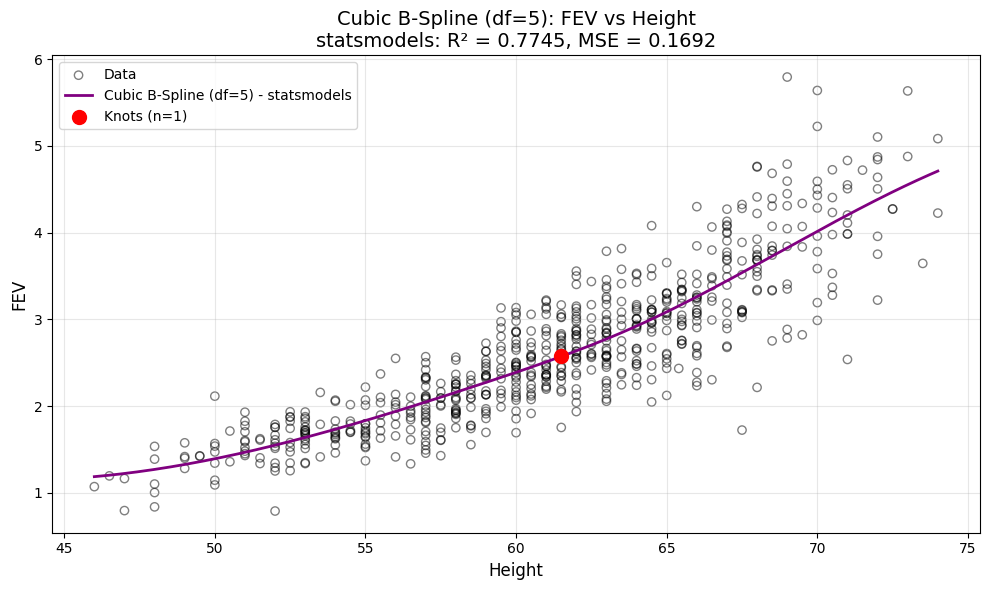

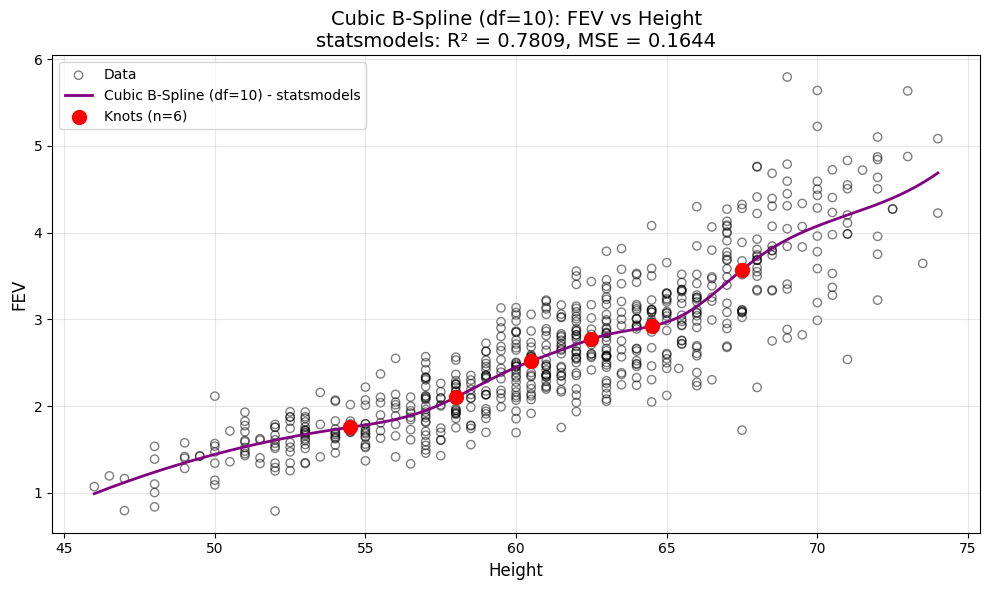

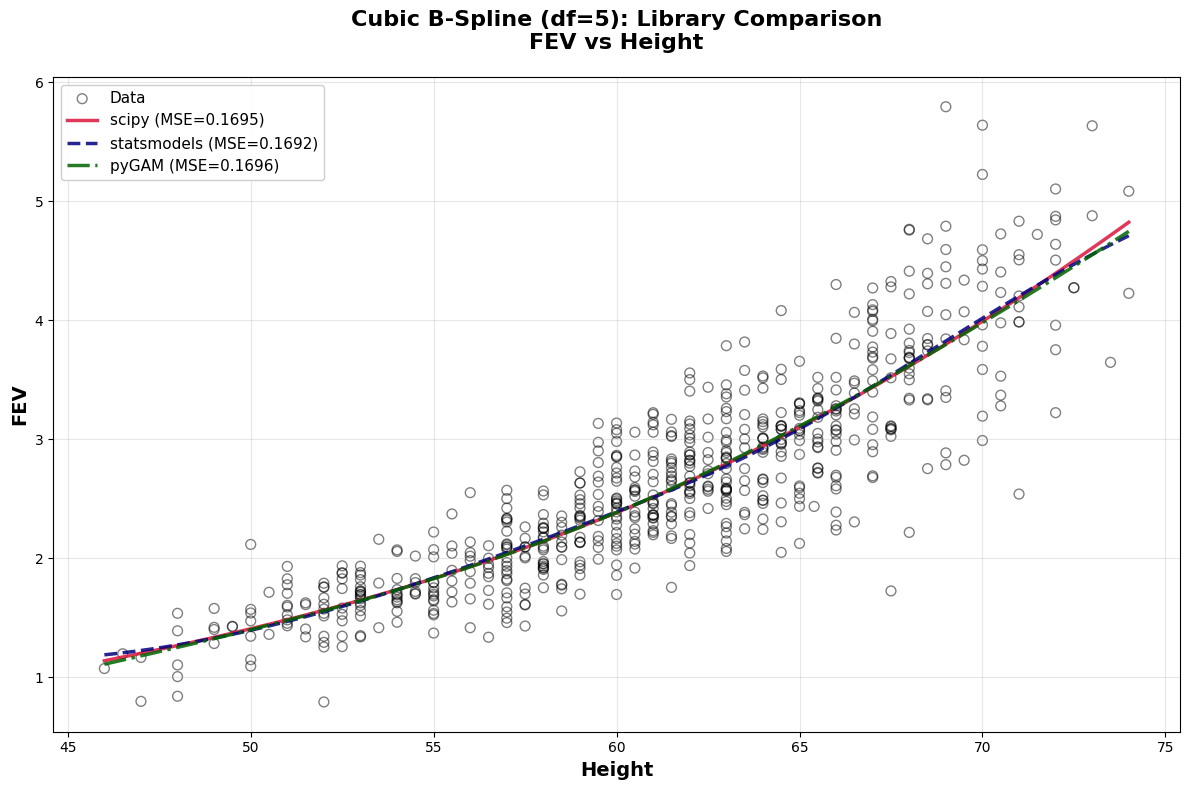

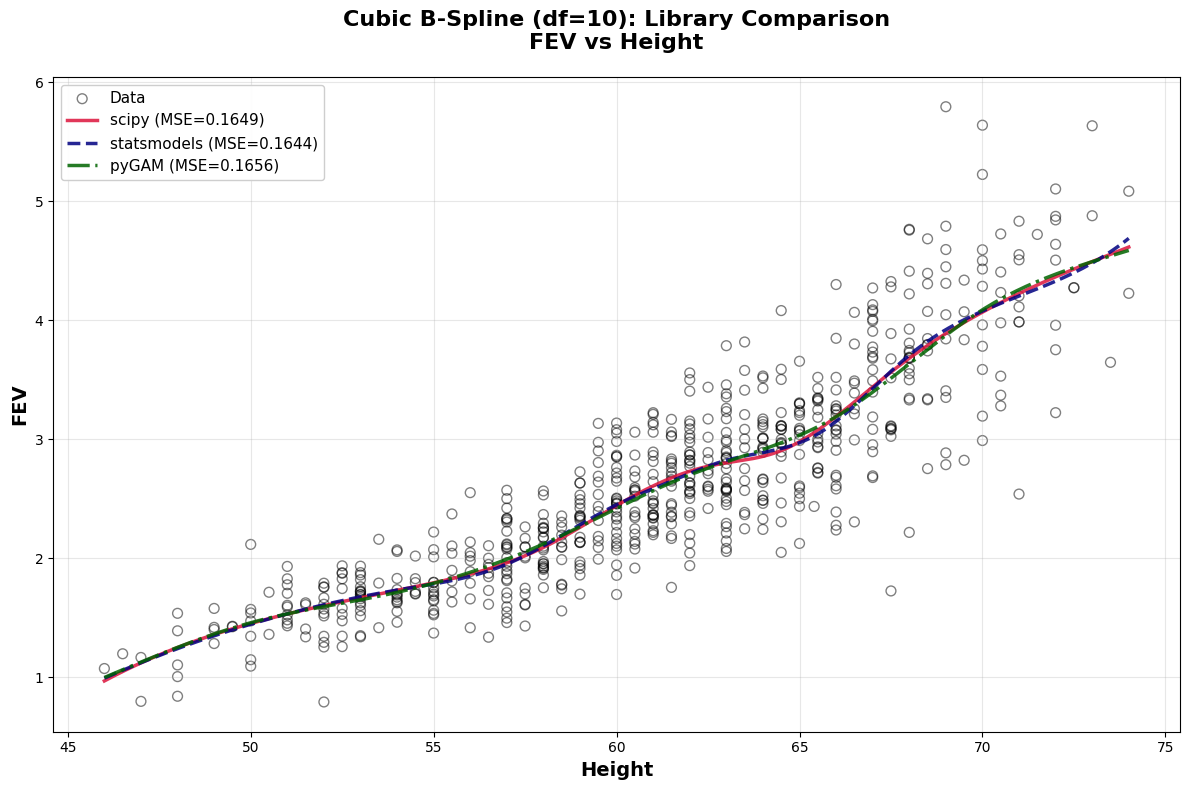

In [15]:
print("Testing df=5 and df=10\n")

sort_idx = np.argsort(X)
X_sorted = X[sort_idx]
y_sorted = y[sort_idx]

results_5, contexts_5 = evaluate_degree(5, X, y, X_sorted, y_sorted, df)
results_10, contexts_10 = evaluate_degree(10, X, y, X_sorted, y_sorted, df)

print_summary(results_5, df_value=5)
print_summary(results_10, df_value=10)

X_plot = np.linspace(X.min(), X.max(), 200)

best_5 = min(results_5, key=lambda r: r['MSE'])
best_context_5 = contexts_5[best_5['Library']]
plot_model(
    X,
    y,
    X_plot,
    best_context_5['predict'](X_plot),
    title=(f'Cubic B-Spline (df=5): FEV vs Height\n'
           f"{best_5['Library']}: R² = {best_5['R²']:.4f}, MSE = {best_5['MSE']:.4f}"),
    curve_label=f"Cubic B-Spline (df=5) - {best_5['Library']}",
    curve_color='purple',
    knots_X=best_context_5.get('knots_x'),
    knots_y=best_context_5.get('knots_y'),
)

best_10 = min(results_10, key=lambda r: r['MSE'])
best_context_10 = contexts_10[best_10['Library']]
plot_model(
    X,
    y,
    X_plot,
    best_context_10['predict'](X_plot),
    title=(f'Cubic B-Spline (df=10): FEV vs Height\n'
           f"{best_10['Library']}: R² = {best_10['R²']:.4f}, MSE = {best_10['MSE']:.4f}"),
    curve_label=f"Cubic B-Spline (df=10) - {best_10['Library']}",
    curve_color='purple',
    knots_X=best_context_10.get('knots_x'),
    knots_y=best_context_10.get('knots_y'),
)

plot_overlay_comparison(
    X=X,
    y=y,
    X_plot=X_plot,
    results=results_5,
    contexts=contexts_5,
    title='Cubic B-Spline (df=5): Library Comparison\nFEV vs Height',
)

plot_overlay_comparison(
    X=X,
    y=y,
    X_plot=X_plot,
    results=results_10,
    contexts=contexts_10,
    title='Cubic B-Spline (df=10): Library Comparison\nFEV vs Height',
)

### 6. Model Comparison: Cross-Validated MSE

Compare all models from sections 2-5 to identify the best performing approach.

In [16]:
all_models = []

best_linear = min(results_linear, key=lambda r: r['MSE'])
all_models.append({
    'Model Type': 'Linear',
    'Library': best_linear['Library'],
    'R²': best_linear['R²'],
    'MSE': best_linear['MSE'],
    'RMSE': best_linear['RMSE']
})

best_nat_5 = min(results_df5, key=lambda r: r['MSE'])
all_models.append({
    'Model Type': 'Natural Cubic Spline (df=5)',
    'Library': best_nat_5['Library'],
    'R²': best_nat_5['R²'],
    'MSE': best_nat_5['MSE'],
    'RMSE': best_nat_5['RMSE']
})

best_nat_10 = min(results_df10, key=lambda r: r['MSE'])
all_models.append({
    'Model Type': 'Natural Cubic Spline (df=10)',
    'Library': best_nat_10['Library'],
    'R²': best_nat_10['R²'],
    'MSE': best_nat_10['MSE'],
    'RMSE': best_nat_10['RMSE']
})

best_smooth = min(results_smoothing, key=lambda r: r['MSE'])
all_models.append({
    'Model Type': 'Smoothing Cubic Spline',
    'Library': best_smooth['Library'],
    'R²': best_smooth['R²'],
    'MSE': best_smooth['MSE'],
    'RMSE': best_smooth['RMSE']
})

best_bs_5 = min(results_5, key=lambda r: r['MSE'])
all_models.append({
    'Model Type': 'Cubic B-Spline (df=5)',
    'Library': best_bs_5['Library'],
    'R²': best_bs_5['R²'],
    'MSE': best_bs_5['MSE'],
    'RMSE': best_bs_5['RMSE']
})

best_bs_10 = min(results_10, key=lambda r: r['MSE'])
all_models.append({
    'Model Type': 'Cubic B-Spline (df=10)',
    'Library': best_bs_10['Library'],
    'R²': best_bs_10['R²'],
    'MSE': best_bs_10['MSE'],
    'RMSE': best_bs_10['RMSE']
})

print("\n" + "="*100)
print("MODEL COMPARISON")
print("="*100)
print(f"{'Model Type':<35} {'Library':<15} {'R²':>12} {'MSE':>12} {'RMSE':>12}")
print("-"*100)

sorted_models = sorted(all_models, key=lambda m: m['MSE'])
for model in sorted_models:
    print(f"{model['Model Type']:<35} {model['Library']:<15} {model['R²']:>12.6f} {model['MSE']:>12.6f} {model['RMSE']:>12.6f}")

print("="*100)

best_overall = sorted_models[0]
print(f"\nBEST MODEL:")
print(f"Type: {best_overall['Model Type']}")
print(f"Library: {best_overall['Library']}")
print(f"R²: {best_overall['R²']:.6f}")
print(f"MSE: {best_overall['MSE']:.6f}")
print(f"RMSE: {best_overall['RMSE']:.6f}")

linear_mse = best_linear['MSE']
best_mse = best_overall['MSE']
improvement = ((linear_mse - best_mse) / linear_mse) * 100
print(f"\nImprovement over linear model: {improvement:.2f}%")


MODEL COMPARISON
Model Type                          Library                   R²          MSE         RMSE
----------------------------------------------------------------------------------------------------
Cubic B-Spline (df=10)              statsmodels         0.780940     0.164435     0.405506
Natural Cubic Spline (df=10)        statsmodels         0.780715     0.164605     0.405715
Smoothing Cubic Spline              pyGAM               0.779479     0.165532     0.406856
Natural Cubic Spline (df=5)         statsmodels         0.774695     0.169124     0.411246
Cubic B-Spline (df=5)               statsmodels         0.774543     0.169237     0.411385
Linear                              scipy.stats         0.753658     0.184914     0.430017

BEST MODEL:
Type: Cubic B-Spline (df=10)
Library: statsmodels
R²: 0.780940
MSE: 0.164435
RMSE: 0.405506

Improvement over linear model: 11.07%


# 2. Classification 

 


The dataset Heart.csv contains on coronary heart disease status (variable chd) and several risk factors including the cumulative tobacco consumption tobacco, systolic sbp, and age


In [17]:
df2 = pd.read_csv('Heart.csv')
df2.head(3)

,id,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0


In [18]:
display(df2.chd.value_counts())

chd
0    302
1    160
Name: count, dtype: int64

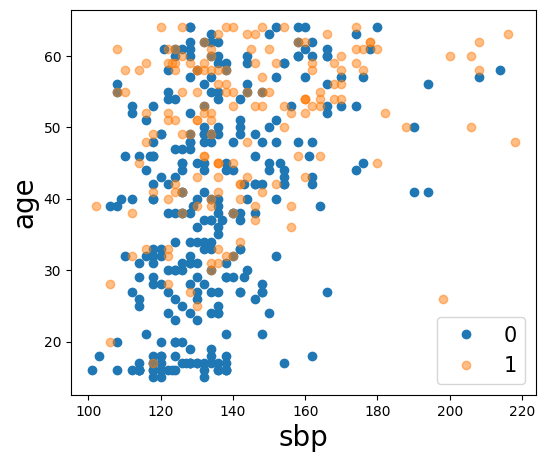

In [19]:
f, ax = plt.subplots(figsize=(6,5))

I_0 = df2["chd"]==0
I_1 = df2["chd"]==1

plt.plot(df2["sbp"][I_0], df2["age"][I_0],'o',label="0")

## We set alpha=.5 to try to avoid masking, but some points still will be burried. 
plt.plot(df2["sbp"][I_1], df2["age"][I_1],'o',label="1",alpha=.5)

plt.xlabel("sbp",fontsize=20)
plt.ylabel("age",fontsize=20)
plt.legend(fontsize=15)

### 1. GAM Logistic Regression for CHD

We'll fit a Generalized Additive Model (GAM) with logistic link function for coronary heart disease (chd) using splines for tobacco, sbp, and age.

In [20]:
from pygam import LogisticGAM, s
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

print("Dataset Information:")
print(f"Total observations: {len(df2)}")
print(f"CHD distribution:")
print(df2['chd'].value_counts())
print(f"\nFeatures: tobacco, sbp, age")

X_features = df2[['tobacco', 'sbp', 'age']].values
y_target = df2['chd'].values

print(f"\nFeature ranges:")
print(f"  Tobacco: [{df2['tobacco'].min():.2f}, {df2['tobacco'].max():.2f}]")
print(f"  SBP: [{df2['sbp'].min():.0f}, {df2['sbp'].max():.0f}]")
print(f"  Age: [{df2['age'].min():.0f}, {df2['age'].max():.0f}]")

X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_target, test_size=0.2, random_state=42, stratify=y_target
)

print(f"\nTrain set: {len(X_train)} observations")
print(f"Test set: {len(X_test)} observations")
print(f"Train CHD prevalence: {y_train.mean():.2%}")
print(f"Test CHD prevalence: {y_test.mean():.2%}")

Dataset Information:
Total observations: 462
CHD distribution:
chd
0    302
1    160
Name: count, dtype: int64

Features: tobacco, sbp, age

Feature ranges:
  Tobacco: [0.00, 31.20]
  SBP: [101, 218]
  Age: [15, 64]

Train set: 369 observations
Test set: 93 observations
Train CHD prevalence: 34.69%
Test CHD prevalence: 34.41%


In [21]:
gam_logistic = LogisticGAM(s(0) + s(1) + s(2))
gam_logistic.gridsearch(X_train, y_train)

print(f"Optimal lambdas found:")
print(f"Tobacco (feature 0): {gam_logistic.lam[0][0]:.4f}")
print(f"SBP (feature 1): {gam_logistic.lam[1][0]:.4f}")
print(f"Age (feature 2): {gam_logistic.lam[2][0]:.4f}")

y_train_pred_proba = gam_logistic.predict_proba(X_train)
y_test_pred_proba = gam_logistic.predict_proba(X_test)

y_train_pred = gam_logistic.predict(X_train)
y_test_pred = gam_logistic.predict(X_test)

train_accuracy = (y_train_pred == y_train).mean()
test_accuracy = (y_test_pred == y_test).mean()

print(f"\nGAM Model Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"\nTraining AUC-ROC: {train_auc:.4f}")
print(f"Test AUC-ROC: {test_auc:.4f}")

print(f"\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['No CHD', 'CHD']))

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Optimal lambdas found:
Tobacco (feature 0): 1000.0000
SBP (feature 1): 1000.0000
Age (feature 2): 1000.0000

GAM Model Performance:
Training Accuracy: 0.6829
Test Accuracy: 0.7849

Training AUC-ROC: 0.7331
Test AUC-ROC: 0.7859

Test Set Classification Report:
              precision    recall  f1-score   support

      No CHD       0.82      0.87      0.84        61
         CHD       0.71      0.62      0.67        32

    accuracy                           0.78        93
   macro avg       0.76      0.75      0.75        93
weighted avg       0.78      0.78      0.78        93



### 2. Baseline: Linear Logistic Regression

Fit a standard logistic regression with linear effects for comparison.

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)

y_train_pred_proba_lr = logreg.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba_lr = logreg.predict_proba(X_test_scaled)[:, 1]

y_train_pred_lr = logreg.predict(X_train_scaled)
y_test_pred_lr = logreg.predict(X_test_scaled)

train_accuracy_lr = (y_train_pred_lr == y_train).mean()
test_accuracy_lr = (y_test_pred_lr == y_test).mean()

print(f"Linear Logistic Regression Performance:")
print(f"Training Accuracy: {train_accuracy_lr:.4f}")
print(f"Test Accuracy: {test_accuracy_lr:.4f}")

train_auc_lr = roc_auc_score(y_train, y_train_pred_proba_lr)
test_auc_lr = roc_auc_score(y_test, y_test_pred_proba_lr)

print(f"\nTraining AUC-ROC: {train_auc_lr:.4f}")
print(f"Test AUC-ROC: {test_auc_lr:.4f}")

feature_names = ['tobacco', 'sbp', 'age']
print(f"\nLogistic Regression Coefficients:")

for feat, coef in zip(feature_names, logreg.coef_[0]):
    print(f"  {feat}: {coef:.4f}")
print(f"  intercept: {logreg.intercept_[0]:.4f}")

print(f"\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred_lr, target_names=['No CHD', 'CHD']))

Linear Logistic Regression Performance:
Training Accuracy: 0.6802
Test Accuracy: 0.7849

Training AUC-ROC: 0.7316
Test AUC-ROC: 0.7859

Logistic Regression Coefficients:
  tobacco: 0.2719
  sbp: 0.1079
  age: 0.7386
  intercept: -0.7638

Test Set Classification Report:
              precision    recall  f1-score   support

      No CHD       0.82      0.87      0.84        61
         CHD       0.71      0.62      0.67        32

    accuracy                           0.78        93
   macro avg       0.76      0.75      0.75        93
weighted avg       0.78      0.78      0.78        93



### 3. Model Comparison: GAM vs Linear Logistic Regression

In [23]:
comparison_data = {
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Train AUC-ROC', 'Test AUC-ROC'],
    'GAM Logistic': [
        f"{train_accuracy:.4f}",
        f"{test_accuracy:.4f}",
        f"{train_auc:.4f}",
        f"{test_auc:.4f}"
    ],
    'Linear Logistic': [
        f"{train_accuracy_lr:.4f}",
        f"{test_accuracy_lr:.4f}",
        f"{train_auc_lr:.4f}",
        f"{test_auc_lr:.4f}"
    ],
    'Difference': [
        f"{train_accuracy - train_accuracy_lr:+.4f}",
        f"{test_accuracy - test_accuracy_lr:+.4f}",
        f"{train_auc - train_auc_lr:+.4f}",
        f"{test_auc - test_auc_lr:+.4f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n")
print(comparison_df.to_string(index=False))

if test_auc > test_auc_lr:
    improvement = ((test_auc - test_auc_lr) / test_auc_lr) * 100
    print(f"GAM outperforms Linear Logistic by {improvement:.2f}% in Test AUC-ROC")
elif test_auc < test_auc_lr:
    decline = ((test_auc_lr - test_auc) / test_auc_lr) * 100
    print(f"GAM underperforms Linear Logistic by {decline:.2f}% in Test AUC-ROC")
else:
    print("Both models have identical Test AUC-ROC performance")



        Metric GAM Logistic Linear Logistic Difference
Train Accuracy       0.6829          0.6802    +0.0027
 Test Accuracy       0.7849          0.7849    +0.0000
 Train AUC-ROC       0.7331          0.7316    +0.0016
  Test AUC-ROC       0.7859          0.7859    +0.0000
Both models have identical Test AUC-ROC performance


### 4. ROC Curve Comparison

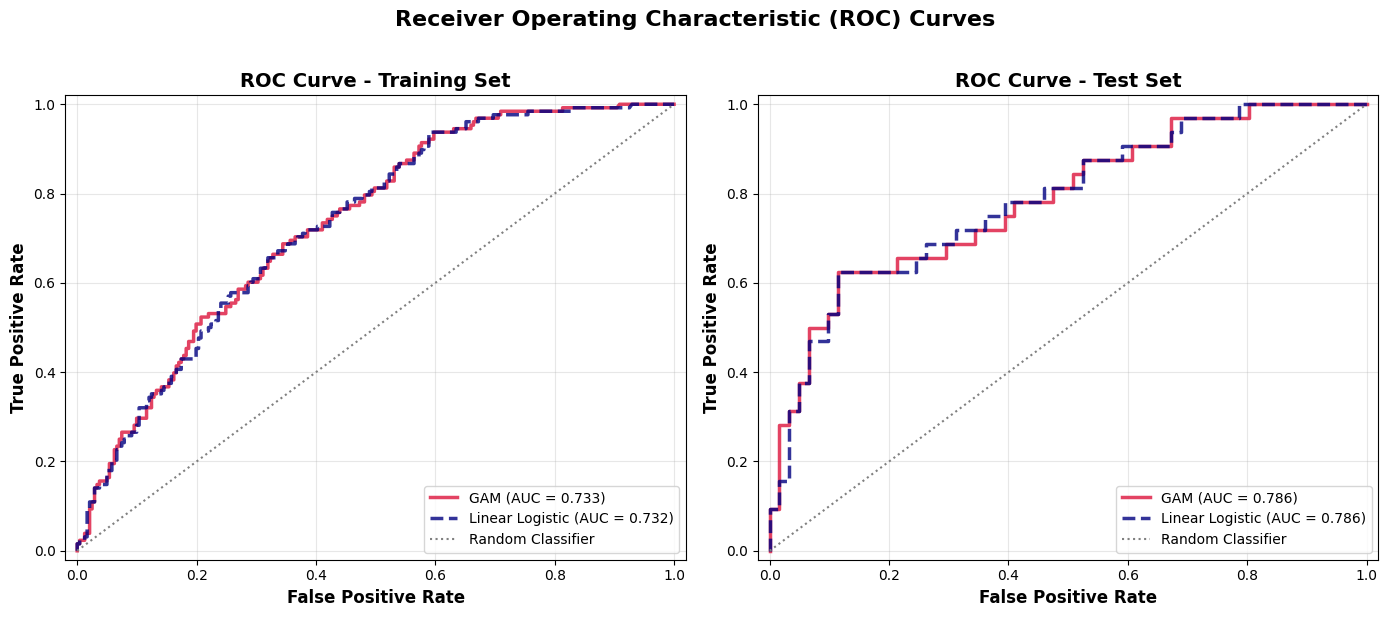

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

fpr_train_gam, tpr_train_gam, _ = roc_curve(y_train, y_train_pred_proba)
fpr_train_lr, tpr_train_lr, _ = roc_curve(y_train, y_train_pred_proba_lr)

ax1.plot(fpr_train_gam, tpr_train_gam, color='crimson', linewidth=2.5, 
         label=f'GAM (AUC = {train_auc:.3f})', alpha=0.8)
ax1.plot(fpr_train_lr, tpr_train_lr, color='navy', linewidth=2.5, 
         label=f'Linear Logistic (AUC = {train_auc_lr:.3f})', alpha=0.8, linestyle='--')
ax1.plot([0, 1], [0, 1], color='gray', linestyle=':', linewidth=1.5, label='Random Classifier')

ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax1.set_title('ROC Curve - Training Set', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([-0.02, 1.02])
ax1.set_ylim([-0.02, 1.02])

fpr_test_gam, tpr_test_gam, _ = roc_curve(y_test, y_test_pred_proba)
fpr_test_lr, tpr_test_lr, _ = roc_curve(y_test, y_test_pred_proba_lr)

ax2.plot(fpr_test_gam, tpr_test_gam, color='crimson', linewidth=2.5, 
         label=f'GAM (AUC = {test_auc:.3f})', alpha=0.8)
ax2.plot(fpr_test_lr, tpr_test_lr, color='navy', linewidth=2.5, 
         label=f'Linear Logistic (AUC = {test_auc_lr:.3f})', alpha=0.8, linestyle='--')
ax2.plot([0, 1], [0, 1], color='gray', linestyle=':', linewidth=1.5, label='Random Classifier')

ax2.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax2.set_title('ROC Curve - Test Set', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim([-0.02, 1.02])
ax2.set_ylim([-0.02, 1.02])

plt.suptitle('Receiver Operating Characteristic (ROC) Curves', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 5. Confusion Matrices

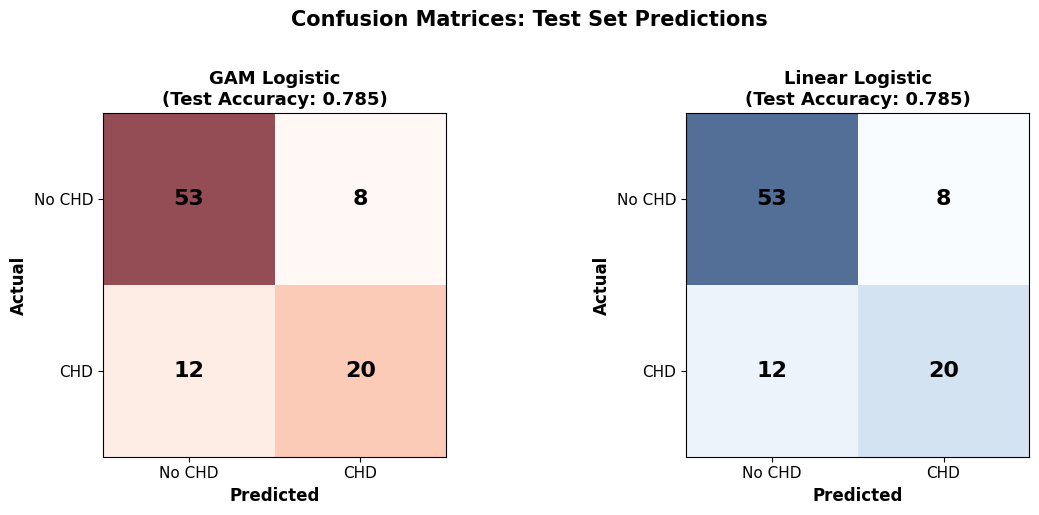

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_gam = confusion_matrix(y_test, y_test_pred)
im1 = axes[0].imshow(cm_gam, cmap='Reds', alpha=0.7)
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['No CHD', 'CHD'], fontsize=11)
axes[0].set_yticklabels(['No CHD', 'CHD'], fontsize=11)
axes[0].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=12, fontweight='bold')
axes[0].set_title(f'GAM Logistic\n(Test Accuracy: {test_accuracy:.3f})',fontsize=13, fontweight='bold')

for i in range(2):
    for j in range(2):
        text = axes[0].text(j, i, f'{cm_gam[i, j]}',ha='center', va='center', color='black', fontsize=16, fontweight='bold')

cm_lr = confusion_matrix(y_test, y_test_pred_lr)
im2 = axes[1].imshow(cm_lr, cmap='Blues', alpha=0.7)
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['No CHD', 'CHD'], fontsize=11)
axes[1].set_yticklabels(['No CHD', 'CHD'], fontsize=11)
axes[1].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=12, fontweight='bold')
axes[1].set_title(f'Linear Logistic\n(Test Accuracy: {test_accuracy_lr:.3f})',fontsize=13, fontweight='bold')

for i in range(2):
    for j in range(2):
        text = axes[1].text(j, i, f'{cm_lr[i, j]}',ha='center', va='center', color='black', fontsize=16, fontweight='bold')

plt.suptitle('Confusion Matrices: Test Set Predictions', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

 The GAM model with spline terms allows for non-linear relationships between predictors and CHD risk, potentially capturing more complex patterns than linear logistic regression.

 Both models' AUC-ROC scores indicate their ability to differentiate between patients with and without CHD. In this dataset, both models achieved identical test performance (AUC-ROC = 0.7859), suggesting the relationships are approximately linear.

- The identical performance suggests simpler linear models are sufficient for this dataset
- Age is the strongest predictor (coefficient = 0.7386)
- Tobacco consumption has moderate effect (coefficient = 0.2719)
- Blood pressure has minimal additional predictive value (coefficient = 0.1079)